In [8]:
using VegaLite
using PlotlyJS
include("./utils.jl")
include("./unit_commitment.jl")
ENV["COLUMNS"]=120 # Set so all columns of DataFrames and Matrices are displayed

120

In [9]:

gen_info, fuels, loads, gen_variable_info, storage_info = read_data()
gen_df = pre_process_generators_data(gen_info, fuels)
storage_df = pre_process_storage_data(storage_info)

# A spring day
n=100
T_period = (n*24+1):((n+1)*24)

# High solar case: 3,500 MW
gen_df_sens = copy(gen_df)
gen_df_sens[gen_df_sens.resource .== "solar_photovoltaic",
    :existing_cap_mw] .= 3500
gen_variable = pre_process_gen_variable(gen_df_sens, gen_variable_info)

# Filtering data with timeseries according to T_period
gen_variable_multi = gen_variable[in.(gen_variable.hour,Ref(T_period)),:];
loads_multi = loads[in.(loads.hour,Ref(T_period)),:];

reserve = DataFrame(
    hour = loads[in.(loads.hour, Ref(T_period)), :hour],
    up = 300 .+ loads[in.(loads.hour,Ref(T_period)), :demand].*0.05,
    down = loads[in.(loads.hour, Ref(T_period)), :demand].*0.05)


energy_reserve = [(row_1.hour, row_2.hour, row_1.up*(row_1.hour == row_2.hour), row_1.down*(row_1.hour == row_2.hour)) for row_1 in eachrow(reserve), row_2 in eachrow(reserve) if row_1.hour <= row_2.hour]
energy_reserve = DataFrame(energy_reserve)
energy_reserve = rename(energy_reserve, :1 => :i_hour, :2 => :t_hour, :3 => :up, :4 => :down,)
;

### Enriched solution

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.001
Adding ramp constraints...


Adding storage...


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 6692 rows, 3720 columns and 17076 nonzeros
Model fingerprint: 0x6ec01c60
Variable types: 1896 continuous, 1824 integer (1824 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+03]
  Objective range  [1e-01, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 3316 rows and 674 columns
Presolve time: 0.04s
Presolved: 3376 rows, 3046 columns, 13026 nonzeros
Variable types: 1266 continuous, 1780 integer (1780 binary)

Root relaxation: objective 6.032806e+05, 566 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    

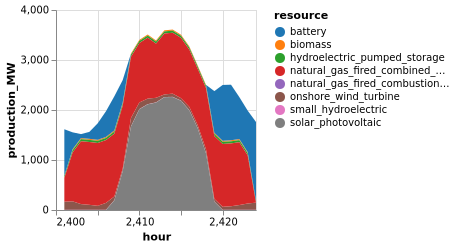

In [10]:
solution = solve_unit_commitment(
    gen_df_sens,
    loads_multi,
    gen_variable_multi,
    0.001,
    ramp_constraints = true,
    storage = storage_df,
    enriched_solution = true);

supply = combine(groupby(solution.generation, [:hour, :resource]), :production_MW => sum, renamecols=false)
supply_ch = combine(groupby(solution.storage, [:hour, :resource]), :discharge_MW => sum, renamecols=false)
rename!(supply_ch, :discharge_MW => :production_MW)
append!(supply, supply_ch)
supply |>
@vlplot(:area, 
    x=:hour, y={:production_MW, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

In [11]:
to_plot = copy(solution.dis)
to_plot.hour = to_plot.hour .- T_period[1]
plot(to_plot, x = :hour, y = :value, group = :r_id)

ErrorException: type NamedTuple has no field dis

In [12]:
to_plot = copy(solution.ch)
to_plot.hour = to_plot.hour .- T_period[1]
plot(to_plot, x = :hour, y = :value, group = :r_id)

ErrorException: type NamedTuple has no field ch